In [1]:
import numpy as np
from gensim.models import Word2Vec
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import backend as K
from SPARQLWrapper import SPARQLWrapper, JSON
from mixed_regression_functions import *
import matplotlib.patches as mpatches

Using TensorFlow backend.


# Import trained models

In [2]:
import pickle

def save_data_with_pickle(relative_path, data):
    """ Save data using pickle (serialize) """

    with open(relative_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_data_with_pickle(relative_path):
    """ Load data using pickle (deserialize) """

    with open(relative_path, 'rb') as handle:
        return pickle.load(handle)

In [3]:
def hyperbolic_loss(y_true, y_pred):    
    num = 8 * tf.norm(y_true - y_pred, axis = 1)
    densx = (4 - tf.norm(y_pred, axis = 1))
    dendx = (4 - tf.norm(y_true, axis = 1))
    denom = densx * dendx
    clipped = tf.clip_by_value(denom,
                               clip_value_min=0.0000001,
                               clip_value_max=10000000)
    frac = num/clipped
    acos = tf.math.acosh(1  + frac)
    acos = tf.diag(acos)
    ret = K.mean(K.mean(acos, axis = -1))
#     mse = K.mean(tf.losses.mean_squared_error(y_true, y_pred))

#     return tf.where(
#         tf.reduce_any(tf.is_nan(acos)),
#         mse * 10, 
#         ret)
    return ret

In [4]:
def hyper_distance(tensor1, tensor2, r = 2):
    return np.arccosh(
        1 + (2 * r**2 *(norm(tensor1 - tensor2) ** 2))
        / ((r**2 - norm(tensor1) ** 2)*(r**2 - norm(tensor2) ** 2)))

In [44]:
from keras.layers import Dropout

def make_network(input_dimension = 0, mixed_dimension = 100):
    if input_dimension == 0:
        input_dimension = word_embedding.wv.vector_size
    type_embedding_dimension = type_embedding.wv.vector_size
    hyper_embedding_dimension = 2

    inp = Input(shape=(input_dimension, ))

    mixed = Dense(int(mixed_dimension * 2), activation = "tanh")(inp)
    droppy = Dropout(rate=0.2)(mixed)
    mixed = Dense(int(mixed_dimension * 2), activation = "tanh")(droppy)
    droppy = Dropout(rate=0.2)(mixed)
    mixed = Dense(mixed_dimension, activation = "tanh")(droppy)
    droppy = Dropout(rate=0.2)(mixed)
    mixed = Dense(mixed_dimension, activation = "tanh")(mixed)


    hyperbolic_embedding_layer = Dense(hyper_embedding_dimension, name='Hyper')(mixed)

    type_embedding_layer = Dense(type_embedding_dimension, name='T2V')(mixed)
    
    return inp, mixed, hyperbolic_embedding_layer, type_embedding_layer

In [7]:
def import_stanford_hyperbolic(PATH):
    dic = load_data_with_pickle('./dic')
    inv_dic = load_data_with_pickle('./inv_dic')
    with open(PATH, 'r') as inp:
        lines = inp.readlines()
        lines = lines[1:]
        lines = [l.replace('\n','') for l in lines]
        tau = float(lines[0].split(',')[-1])
        stanford_emb = {inv_dic[l.split(',')[0]]: np.array(l.split(',')[1:-1]).astype('float64') for l in lines}
    return stanford_emb, tau

In [8]:
def get_parenthood(classes):
    parenthood = {}
    
    for clas in classes:
        
        parenthood[clas] = {}
        
        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        sparql.setQuery("""
        PREFIX rdf:<http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX vrank:<http://purl.org/voc/vrank#>
        PREFIX dbo:<http://dbpedia.org/ontology/>
            SELECT distinct ?s
            FROM <http://dbpedia.org> 
            FROM <http://people.aifb.kit.edu/ath/#DBpedia_PageRank> 
            WHERE { ?s rdfs:subClassOf dbo:""" + clas + """.
                   }
        """)

        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()

        collector = []

        for result in results["results"]["bindings"]:
            data_a = result["s"]["value"].replace("http://dbpedia.org/ontology/", "")
            if 'http://www.w3.org/2002/07/owl#Thing' not in data_a:
                collector.append((data_a))
        
        parenthood[clas]['sons'] = collector
        
        sparql.setQuery("""
        PREFIX rdf:<http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX vrank:<http://purl.org/voc/vrank#>
        PREFIX dbo:<http://dbpedia.org/ontology/>
            SELECT distinct ?s
            FROM <http://dbpedia.org> 
            FROM <http://people.aifb.kit.edu/ath/#DBpedia_PageRank> 
            WHERE { dbo:""" + clas + """ rdfs:subClassOf ?s.
                   }
        """)

        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()

        collector = []

        for result in results["results"]["bindings"]:
            data_a = result["s"]["value"].replace("http://dbpedia.org/ontology/", "")
            if 'http://www.w3.org/2002/07/owl#Thing' not in data_a:
                collector.append((data_a))
        
        parenthood[clas]['ancestors'] = collector
        
        
        sparql.setQuery("""
        PREFIX rdf:<http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX vrank:<http://purl.org/voc/vrank#>
        PREFIX dbo:<http://dbpedia.org/ontology/>
            SELECT distinct ?v ?s
            FROM <http://dbpedia.org> 
            FROM <http://people.aifb.kit.edu/ath/#DBpedia_PageRank> 
            WHERE { dbo:""" + clas + """ rdfs:subClassOf ?s.
                    ?v rdfs:subClassOf ?s.
                   }
        """)

        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()

        collector = []

        for result in results["results"]["bindings"]:
            data_a = result["v"]["value"].replace("http://dbpedia.org/ontology/", "")
            data_b = result["s"]["value"].replace("http://dbpedia.org/ontology/", "")
            if 'http://www.w3.org/2002/07/owl#Thing' not in data_b:
                collector.append((data_a))
        parenthood[clas]['siblings'] = [c for c in collector if c != clas]
        
    return parenthood

In [9]:
HYPERBOLIC_EMBEDDING_PATH = "/datahdd/vmanuel/hyperbolic_embedding_algorithms/HyperE-Stanford/hyperbolics/dbpedia.r2.emb"
TYPE_EMBEDDING_PATH = "/datahdd/vmanuel/datasets/t2v.bin"
hyperbolic_embedding = import_stanford_hyperbolic(HYPERBOLIC_EMBEDDING_PATH)[0]
type_embedding = Word2Vec.load(TYPE_EMBEDDING_PATH)

In [45]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network(1024, 256)

early_stop = EarlyStopping(monitor='val_loss', patience = 30, restore_best_weights=True)

mixed_model = Model(input=inp, output=[type_embedding_layer, hyperbolic_embedding_layer])
mixed_model.compile(optimizer='adam', loss=['cosine_proximity', hyperbolic_loss])
mixed_model.load_weights('/datahdd/vmanuel/datasets/models/datas/16_classes/mixed_model_weights')

/home/vmanuel/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  """


In [46]:
# mixed_encoder = Model(input=inp, output=mixed)
# mixed_encoder.set_weights(mixed_model.get_weights()[0:8])

/home/vmanuel/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [11]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network(200, 100)

early_stop = EarlyStopping(monitor='val_loss', patience = 30, restore_best_weights=True)

mo_mixed_model = Model(input=inp, output=[type_embedding_layer, hyperbolic_embedding_layer])
mo_mixed_model.compile(optimizer='adam', loss=['cosine_proximity', hyperbolic_loss])
mo_mixed_model.load_weights('/datahdd/vmanuel/datasets/models/datas/16_classes/mo_mixed_model')

/home/vmanuel/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  """


In [12]:
# classes = ['Mammal'
#          , 'Planet'
#          , 'Company'
#          , 'City'
#          , 'Plant'
#          , 'AnatomicalStructure'
# #          , 'Food'
#           ]


In [13]:
# parenthood = get_parenthood(classes)

In [90]:
# classes_to_invent = [v['siblings'] for v in parenthood.values()]
# classes_to_invent = [s for sublist in classes_to_invent for s in sublist]

classes_to_invent = ['Currency', 'Amphibian', 'Crustacean', 'SportsLeague', 'Mollusca', 'Game', 'GovernmentAgency', 'Reptile', 'EducationalInstitution'
                    , 'Fish']

In [13]:
words_to_invent = []
for t in classes_to_invent:
    words_to_invent.append(get_from_class('dbo:' + t))

In [26]:
save_data_with_pickle('/datahdd/vmanuel/datasets/words_to_invent', words_to_invent)
save_data_with_pickle('/datahdd/vmanuel/datasets/classes_to_invent', classes_to_invent)


## GO TO import_Elmo_Embeddings.ipynb to see the retrieving

In [91]:
X_invention = load_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/16_classes/X_invention_1')
Y_invention = load_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/16_classes/Y_invention_1')
word_invention = load_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/16_classes/word_invention_1')

encoded_invention = mixed_encoder.predict(X_invention)

In [92]:
[len(X_invention), len(Y_invention), len(word_invention)]

[5062, 5062, 5062]

# Centroid Prediction

In [103]:
predicted_d, predicted_h = mixed_model.predict(np.array(X_invention[:1000]))
# mo_predicted_d, mo_predicted_h = mo_mixed_model.predict(np.array(encoded_invention))

In [104]:
differences = {l: [] for l in set(Y_invention)}
points = {l: [] for l in set(Y_invention)}

# mo_differences = {l: [] for l in set(Y_invention)}
# mo_points = {l: [] for l in set(Y_invention)}
for p, label in zip(predicted_h, Y_invention):
# for p, label, mo_p in zip(predicted_h, Y_invention, mo_predicted_h):
    differences[label].append(hyper_distance(p, hyperbolic_embedding[label], 1))
    points[label].append(p)
    
#     mo_differences[label].append(hyper_distance(mo_p, hyperbolic_embedding[label], 2))
#     mo_points[label].append(mo_p)
    

/home/vmanuel/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arccosh
  after removing the cwd from sys.path.


In [105]:
[[k, np.nanmean(np.array(v))] for k, v in zip(differences.keys(), differences.values())]

[['Amphibian', 14.966537317426795],
 ['SportsLeague', 11.912360186289566],
 ['Currency', 5.958630992042109],
 ['Fish', 17.63608400146816],
 ['Mollusca', 17.98680157305878],
 ['Reptile', 16.473164143945173],
 ['Crustacean', 17.28504661194276],
 ['EducationalInstitution', 11.126269563737225],
 ['Game', 10.025064565850768],
 ['GovernmentAgency', 14.7434455304816]]

In [106]:
classes_to_invent

['Currency',
 'Amphibian',
 'Crustacean',
 'SportsLeague',
 'Mollusca',
 'Game',
 'GovernmentAgency',
 'Reptile',
 'EducationalInstitution',
 'Fish']

In [107]:
# class_to_plot = [k for k in parenthood['Mammal']['siblings']]
# class_to_plot.append('PublicTransitSystem')

class_to_plot = classes_to_invent

to_plot = [hyperbolic_embedding[k] for k in class_to_plot]

X_plot = [x[0] for x in to_plot]
Y_plot = [x[1] for x in to_plot]

invented_classes_points = {k: [] for k in class_to_plot}
mo_invented_classes_points = {k: [] for k in class_to_plot}

In [108]:
class_to_plot

['Currency',
 'Amphibian',
 'Crustacean',
 'SportsLeague',
 'Mollusca',
 'Game',
 'GovernmentAgency',
 'Reptile',
 'EducationalInstitution',
 'Fish']

In [109]:
colors = ['b', 'c', 'r', 'g', 'm', '#d3d3d3', 'k', '#964b00', '#ffa500', '#ff69b4']
color_map = {cla: col for cla,col in zip(class_to_plot, colors)}
verbose_color = ['Blue', 'Cyan', 'Red', 'Green', 'Magenta', 'Grey', 'Black', 'Brown', 'Orange', 'Pink']
verbose_color_map = {x: y for x,y in zip(color_map.keys(), verbose_color)}

In [110]:

patchList = []
for key in verbose_color_map.keys():
    data_key = mpatches.Patch(color=verbose_color_map[key], label=key)
    patchList.append(data_key)

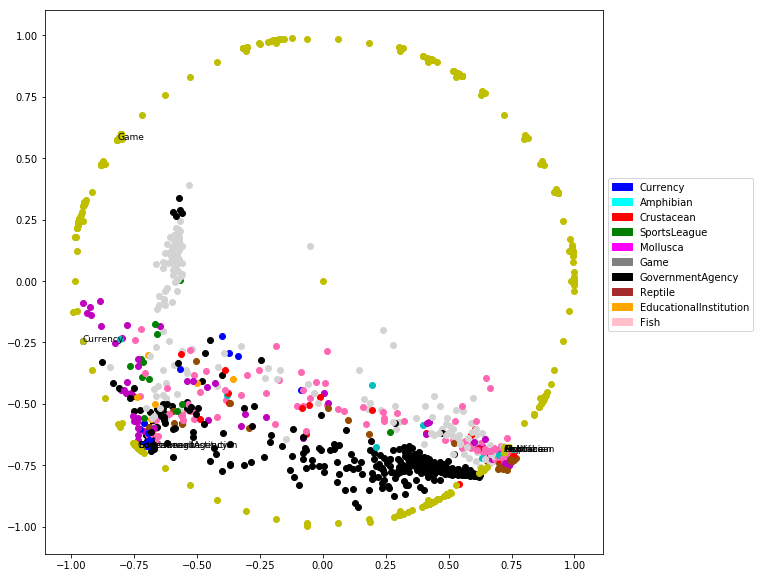

In [112]:

plt.figure(figsize=(10, 10))
# plt.subplot(121)

tot = len(X_plot)

prec = 0

fors = 0
fors += 1
for i, (x, y, c) in enumerate(zip(X_plot, Y_plot, class_to_plot)):
    
#     plt.xlim((min(X_plot) - 1e-6 , max(X_plot) + 1e-6))
#     plt.ylim((min(Y_plot) - 1e-6, max(Y_plot) + 1e-6))
    plt.scatter(x, y, c = color_map[c])
    plt.text(x+0.0000001, y +0.0000001, c, fontsize = 9)    
    
    perc = round(i/tot,2)
    
    if perc != perc:
        clear_output()
        prec = perc
        print(fors+prec)
    
tot = len(predicted_h)
fors += 1
for i, (point, label) in enumerate(zip(predicted_h, Y_invention)):
    if label in class_to_plot:
        plt.scatter(point[0], point[1], c = color_map[label])
        invented_classes_points[label].append(point)
        
    perc = round(i/tot,2)
    
    if perc != perc:
        clear_output()
        prec = perc
        print(fors+prec)

for l, p in zip(hyperbolic_embedding.keys(), hyperbolic_embedding.values()):
    plt.scatter(p[0], p[1], c = 'y')
        
# plt.subplot(122)
# for x, y, c in zip(X_plot, Y_plot, class_to_plot):
# #     plt.xlim((min(X_plot) - 1e-6 , max(X_plot) + 1e-6))
# #     plt.ylim((min(Y_plot) - 1e-6, max(Y_plot) + 1e-6))
#     plt.scatter(x, y, c = color_map[c])
#     plt.text(x+0.0000001, y +0.0000001, c, fontsize = 9)    
    
# for point, label in zip(mo_predicted_h, Y_invention):
#     if label in class_to_plot:
#         plt.scatter(point[0], point[1], c = color_map[label])
#         mo_invented_classes_points[label].append(point)
        
# for l, p in zip(hyperbolic_embedding.keys(), hyperbolic_embedding.values()):
#     plt.scatter(p[0], p[1], c = 'y')

plt.legend(handles=patchList, bbox_to_anchor=(1, 0.7))

# for i, cl in enumerate(class_to_plot):
#     if cl != 'Animal':
#         print('distace between {} and {}: {}'.format('Animal', 
#                                                      cl, 
#                                                      hyper_distance(
#                                                          hyperbolic_embedding['Animal'],
#                                                          hyperbolic_embedding[cl], 
#                                                      r = 2)))

plt.savefig('./im/16_classes/all_invention_predictions_1', dpi = 100)

plt.show()

### Hyperbolic Midpoint Functions

In [113]:
def lorentzian(v0, v1):
    prod = 0
    for i in range(len(v0) - 1):
        prod += v0[i] * v1[i]
    
    ret = - prod + (v0[len(v0) - 1] * v1[len(v1) - 1])
    return abs(ret)


def hyperboloid_projection(v, r):
    n = norm(v)
    t = [(r**2 + (n ** 2)) / (r**2 - (n ** 2))]
    projected = [(2 * r**2 * vs) /(r**2 - (n ** 2)) for vs in v]
    projected.extend(t)
    return np.array(projected)

def inverse_projection(v, r):
    return np.array([vs/(r**2 + v[-1]) for vs in v[:-1]])

def midpoint(vectors, r = 1, n = False):
    if n:
        hv = [hyperboloid_projection(vs, r) if norm(vs) < 1 else - hyperboloid_projection(vs, r) for vs in vectors]
    else:
        hv = [hyperboloid_projection(vs, r) for vs in vectors]
    summ = sum(hv)
    midpoint = summ/np.sqrt(lorentzian(summ, summ))
    poincarè_midpoint = inverse_projection(midpoint, r)
    
    return poincarè_midpoint 

In [114]:
[len(v) for v in invented_classes_points.values()]

[112, 28, 68, 28, 160, 368, 824, 112, 12, 288]

In [115]:
centroids = {k: midpoint(invented_classes_points[k], n = True) for k in class_to_plot if invented_classes_points[k] != []}
# mo_centroids = {k: midpoint(mo_invented_classes_points[k], n = True) for k in class_to_plot if invented_classes_points[k] != []}

centroids

{'Currency': array([-0.67472721, -0.64528995]),
 'Amphibian': array([ 0.58013931, -0.59612078]),
 'Crustacean': array([ 0.55220026, -0.59361711]),
 'SportsLeague': array([-0.55981146, -0.41920397]),
 'Mollusca': array([ 0.32661435, -0.43981219]),
 'Game': array([ 0.39185114, -0.47699035]),
 'GovernmentAgency': array([ 0.20490804, -0.52601873]),
 'Reptile': array([ 0.53013732, -0.56881767]),
 'EducationalInstitution': array([-0.62056285, -0.44504454]),
 'Fish': array([ 0.59233484, -0.60579974])}

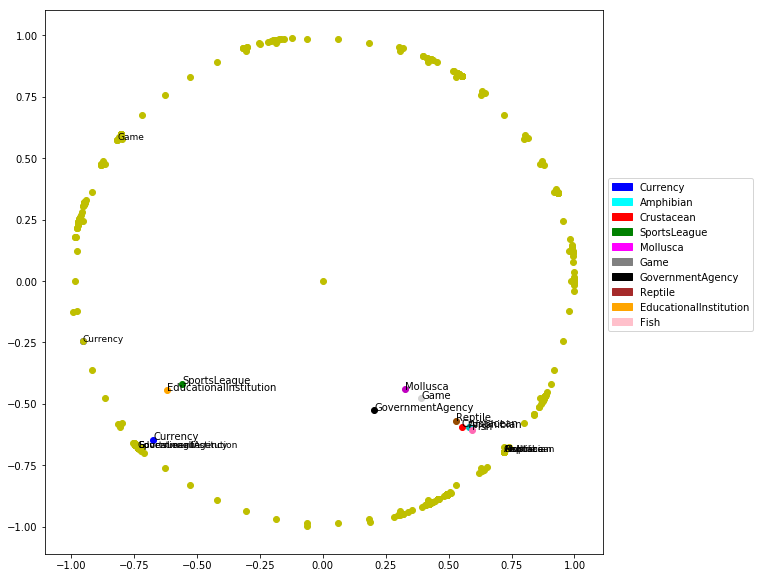

In [118]:
X_plot = [x[0] for x in to_plot]
Y_plot = [x[1] for x in to_plot]

# parentt = 'Animal' 
# parent = hyperbolic_embedding[parentt]

plt.figure(figsize=(10, 10))
# plt.subplot(221)
for x, y, c in zip(X_plot, Y_plot, class_to_plot):
#     plt.xlim((min(X_plot) - 1e-6 , max(X_plot) + 1e-6))
#     plt.ylim((min(Y_plot) - 1e-6, max(Y_plot) + 1e-6))
    plt.scatter(x, y, c = color_map[c])
    plt.text(x+0.0000001, y +0.0000001, c, fontsize = 9)    

# plt.scatter(parent[0], parent[1], c = color_map[c])
# plt.text(parent[0], parent[1], parentt)
    
for point, label in zip(centroids.values(), centroids.keys()):
    if label in class_to_plot:
        plt.scatter(point[0], point[1], c = color_map[label])
        invented_classes_points[label].append(point)
        plt.text(point[0], point[1], label)
        
for l, p in zip(hyperbolic_embedding.keys(), hyperbolic_embedding.values()):
    plt.scatter(p[0], p[1], c = 'y')

        
# plt.subplot(222)
# for x, y, c in zip(X_plot, Y_plot, class_to_plot):
#     plt.xlim((min(X_plot) - 1e-6 , max(X_plot) + 1e-6))
#     plt.ylim((min(Y_plot) - 1e-6, max(Y_plot) + 1e-6))
#     plt.scatter(x, y, c = color_map[c])
#     plt.text(x+0.0000001, y +0.0000001, c, fontsize = 9) 
    

# # plt.scatter(parent[0], parent[1], c = 'tab:orange')
# # plt.text(parent[0], parent[1], parentt)

# plt.subplot(223)
# for x, y, c in zip(X_plot, Y_plot, class_to_plot):
# #     plt.xlim((min(X_plot) - 1e-6 , max(X_plot) + 1e-6))
# #     plt.ylim((min(Y_plot) - 1e-6, max(Y_plot) + 1e-6))
#     plt.scatter(x, y, c = color_map[c])
#     plt.text(x+0.0000001, y +0.0000001, c, fontsize = 9)    

# # plt.scatter(parent[0], parent[1], c = 'tab:orange')
# # plt.text(parent[0], parent[1], parentt)
    
# # for point, label in zip(mo_centroids.values(), mo_centroids.keys()):
# #     if label in class_to_plot:
# #         plt.scatter(point[0], point[1], c = color_map[label])
# #         mo_invented_classes_points[label].append(point)
# #         plt.text(point[0], point[1], label)

# for l, p in zip(hyperbolic_embedding.keys(), hyperbolic_embedding.values()):
#     plt.scatter(p[0], p[1], c = 'y')


        
# plt.subplot(224)
# for x, y, c in zip(X_plot, Y_plot, class_to_plot):
#     plt.xlim((min(X_plot) - 1e-6 , max(X_plot) + 1e-6))
#     plt.ylim((min(Y_plot) - 1e-6, max(Y_plot) + 1e-6))
#     plt.scatter(x, y, c = color_map[c])
#     plt.text(x+0.0000001, y +0.0000001, c, fontsize = 9) 
    

# # plt.scatter(parent[0], parent[1], c = 'tab:orange')
# # plt.text(parent[0], parent[1], parentt)
    
plt.legend(handles=patchList, bbox_to_anchor=(1, 0.7))



# for i, cl in enumerate(class_to_plot):
#     if cl != 'Animal':
#         print('distace between {} and {}: {}'.format('Animal', 
#                                                      cl, 
#                                                      hyper_distance(
#                                                          hyperbolic_embedding['Animal'],
#                                                          hyperbolic_embedding[cl], 
#                                                      r = 2)))
plt.savefig('./im/16_classes/centroids_prediction_1', dpi = 100)
plt.show()

In [37]:
regr = load_data_with_pickle('/datahdd/vmanuel/datasets/models/random_regr')

In [38]:
# preds = mixed_model.predict(X_invention)[1]
preds = regr.predict(X_invention)

class_dists = {c:[] for c in classes_to_invent}
class_points = {c:[] for c in classes_to_invent}

for i, p in enumerate(preds):
    d = hyper_distance(p, hyperbolic_embedding[Y_invention[i]], r=1)
    class_dists[Y_invention[i]].append(d)
    class_points[Y_invention[i]].append(p)   
    
centroids = {}
for c in classes_to_invent:
    centroids[c] = midpoint(class_points[c])
#     euclids[c] = np.sum(np.array(class_points[c])/len(class_points[c]), axis=0)

In [36]:
print('-----------------------------------------------------------------------------------------------------------')
print('{:^105}'.format('Mixed Network Predictions'))
print('-----------------------------------------------------------------------------------------------------------')
print('{:^35}|{:^35}|{:^35}'.format('Class', 'mean hyper distance', 'centroid hyper distance'))
print('-----------------------------------|-----------------------------------|-----------------------------------')
for (x, y), (w, z) in zip(class_dists.items(), centroids.items()):
    print('{:^35}|{:^35.4f}|{:^35.4f}'.format(x, np.mean(y), hyper_distance(z, hyperbolic_embedding[w], 1))) 
print('-----------------------------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------------------------
                                       Single Network Predictions                                        
-----------------------------------------------------------------------------------------------------------
               Class               |        mean hyper distance        |      centroid hyper distance      
-----------------------------------|-----------------------------------|-----------------------------------
             Currency              |              6.9127               |              6.0307               
             Amphibian             |              13.9891              |              14.8763              
            Crustacean             |              16.8065              |              17.6179              
           SportsLeague            |              11.1408              |              11.1864              
             Mollusca         

In [39]:
print('-----------------------------------------------------------------------------------------------------------')
print('{:^105}'.format('Mixed Network Predictions'))
print('-----------------------------------------------------------------------------------------------------------')
print('{:^35}|{:^35}|{:^35}'.format('Class', 'mean hyper distance', 'centroid hyper distance'))
print('-----------------------------------|-----------------------------------|-----------------------------------')
for (x, y), (w, z) in zip(class_dists.items(), centroids.items()):
    print('{:^35}|{:^35.4f}|{:^35.4f}'.format(x, np.mean(y), hyper_distance(z, hyperbolic_embedding[w], 1))) 
print('-----------------------------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------------------------
                                        Mixed Network Predictions                                        
-----------------------------------------------------------------------------------------------------------
               Class               |        mean hyper distance        |      centroid hyper distance      
-----------------------------------|-----------------------------------|-----------------------------------
             Currency              |              4.3130               |              4.2259               
             Amphibian             |              15.4666              |              15.4625              
            Crustacean             |              17.9995              |              17.9686              
           SportsLeague            |              12.0680              |              11.9776              
             Mollusca         

In [46]:
hyperbolic_embedding['Mammal']

array([ 0.71934518, -0.69465275])

In [49]:
norm(hyperbolic_embedding['Fish'])

0.9999999802263263

In [48]:
hyperbolic_embedding['Plant']

array([ 0.71906625, -0.69493739])

In [67]:
centroids

{'Amphibian': array([ 0.61559476, -0.54458815]),
 'Arachnid': array([ 0.53466742, -0.54810841]),
 'Bird': array([ 0.50187935, -0.62396362]),
 'Crustacean': array([ 0.58300666, -0.66123321]),
 'Fish': array([ 0.4083049 , -0.54499309]),
 'Insect': array([ 0.41127786, -0.86020418]),
 'Mollusca': array([ 0.12204813, -0.25863698]),
 'Reptile': array([ 0.60954836, -0.5834286 ])}

In [68]:
class_to_plot

['Amphibian',
 'Arachnid',
 'Bird',
 'Crustacean',
 'Fish',
 'Insect',
 'Mollusca',
 'Reptile']

In [69]:
d = {i: [] for i in class_to_plot}
mins = {i: [] for i in class_to_plot}
ret = {i: [] for i in class_to_plot}
classes_and_animal = classes + [parentt]
print(classes_and_animal)
for i in class_to_plot:
    for c in classes_and_animal:
        try:
            d[i].append(['{} - {}'.format(c, i), hyper_distance(hyperbolic_embedding[c], centroids[i], r = 2)])
        except:
            pass
for i in class_to_plot:
    try:
        mins[i] = min([x[1] for x in d[i]])
    except:
        mins[i] = ['None']
for i in class_to_plot:
    ret[i] = [x[0] for x in d[i] if x[1] == mins[i]]

ret

['Mammal', 'Planet', 'Company', 'City', 'Plant', 'AnatomicalStructure', 'Food', 'Animal']


{'Amphibian': ['Animal - Amphibian'],
 'Arachnid': ['Plant - Arachnid'],
 'Bird': ['Plant - Bird'],
 'Crustacean': ['Plant - Crustacean'],
 'Fish': ['Plant - Fish'],
 'Insect': ['City - Insect'],
 'Mollusca': ['City - Mollusca'],
 'Reptile': ['Animal - Reptile']}

In [70]:
Y_invention

array(['PoliticalParty', 'MilitaryUnit', 'Broadcaster', ...,
       'MilitaryUnit', 'MilitaryUnit', 'MilitaryUnit'], dtype='<U22')

In [71]:
class_to_plot

['Amphibian',
 'Arachnid',
 'Bird',
 'Crustacean',
 'Fish',
 'Insect',
 'Mollusca',
 'Reptile']

### Create collection of words : [points]

In [41]:
splitted = [w.split('_')[0] for w in word_invention]
unique = set(splitted)
inv_points = {c: {}  for c in class_to_plot}
for w, y, p in zip(splitted, Y_invention, X_invention):
    if y in class_to_plot:
        try:
            inv_points[y][w].append(p)
        except:
            inv_points[y][w] = [p]

{'Amphibian': {'toad': [array([ 0.30360588, -0.6094445 , -0.1502215 , ..., -0.33656052,
           0.95259666,  0.78007644], dtype=float32),
   array([-0.29737577, -0.53387487,  0.24578367, ..., -0.3312519 ,
           0.80733687,  0.2472725 ], dtype=float32),
   array([-0.00180233, -0.40458304, -0.04902865, ...,  0.13876529,
           1.3264278 ,  0.75159514], dtype=float32),
   array([-0.04239879, -0.685791  , -0.48352635, ..., -0.37888223,
           0.572223  ,  0.5464824 ], dtype=float32),
   array([ 0.11432074, -0.27310646, -0.25337443, ..., -0.34337524,
           1.1075776 ,  0.8410778 ], dtype=float32),
   array([ 0.13810238, -0.6945156 , -0.21157134, ..., -0.15966353,
           0.8315108 ,  0.26914012], dtype=float32),
   array([ 0.3888768 , -0.8197113 , -0.13434708, ..., -0.58502716,
           0.9467878 ,  0.8726975 ], dtype=float32),
   array([ 0.0124669 , -0.63651735, -0.1807341 , ..., -0.3302464 ,
           1.1556114 ,  0.44016147], dtype=float32),
   array([ 0.040493

### Calculate Distance from Cluster

In [42]:
train_dataset = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/80k/X_train')
train_labels = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/80k/Y_train')
word_train = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/80k/word_train')

In [43]:
train_points = {k: [] for k in set(train_labels)}
for p, l in zip(train_dataset, train_labels):
    train_points[l].append(p)


In [44]:
from scipy.spatial.distance import cdist
from mixed_regression_functions import *

def distance_from_cluster(vec, train_vector_types_dict):
    dist = {k: 0 for k in train_vector_types_dict.keys()}
    for k in train_vector_types_dict.keys():
        d = cdist(vec, 
                  train_vector_types_dict[k], 
                  cos_sim)
        m = np.nanmean(d)
        inds = np.where(np.isnan(d))
        d[inds] = m
        dist[k] = np.mean(d[0])
    return dist

### mean cluster similarity and distance from predicted point correlation analysis

In [57]:
res = {'mcs' : [], 'ds' : [], 'words': [], 'centroids':[]}
i = 0
for k in inv_points.keys():
    keys = inv_points[k].keys()
    for w in keys:
        mcs = distance_from_cluster(inv_points[k][w], {'Mammal' : train_points['Mammal']})['Mammal']
        preds = mixed_model.predict(np.array(inv_points[k][w]))[1]
        centroid = midpoint(preds)
        ds = hyper_distance(centroid, hyperbolic_embedding[k])
        res['mcs'].append(mcs)
        res['ds'].append(ds)
        res['words'].append(w)
        res['centroids'].append(centroid)
        
        clear_output()
        print(i)
        i += 1   
       

815


In [ ]:
# res['ds'] = []
# for k in inv_points.keys():
#     keys = inv_points[k].keys()
#     for w in keys:
#         preds = mixed_model.predict(np.array(inv_points[k][w]))[1]
#         centroid = midpoint(preds)
#         ds = hyper_distance(centroid, hyperbolic_embedding[k], r = 2)
#         res['ds'].append(ds)
        
#         clear_output()
#         print(i)
#         i += 1   

In [58]:
ress = {}
ress['mcs'] = np.array([x for i, x in enumerate(res['mcs']) if not np.isnan(res['ds'][i])])
ress['ds'] = np.array([x for i, x in enumerate(res['ds']) if not np.isnan(x)])
ress['words'] = np.array([x for i, x in enumerate(res['words']) if not np.isnan(res['ds'][i])])
ress['centroids'] = np.array([x for i, x in enumerate(res['centroids']) if not np.isnan(res['ds'][i])])


In [59]:
np.corrcoef(ress['mcs'], ress['ds'])

array([[ 1.        , -0.18247248],
       [-0.18247248,  1.        ]])

In [60]:
np.quantile(ress['mcs'], 0.2)

0.29333273798130305

In [61]:

import pandas as pd

a = [[m, d] for m, d in zip(ress['mcs'], ress['ds'])]

panda = pd.DataFrame(a, columns=['mcs', 'ds'])
panda.head()

,mcs,ds
0,0.344162,0.078970
1,0.281805,0.641250
2,0.339727,0.352904
3,0.300873,0.530751
4,0.312594,0.480628


In [62]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield np.mean(l[i:i + n])

In [67]:
mcs1 = list(chunks(list(panda['mcs']), 45))
ds1 = list(chunks(list(panda['ds']), 45))

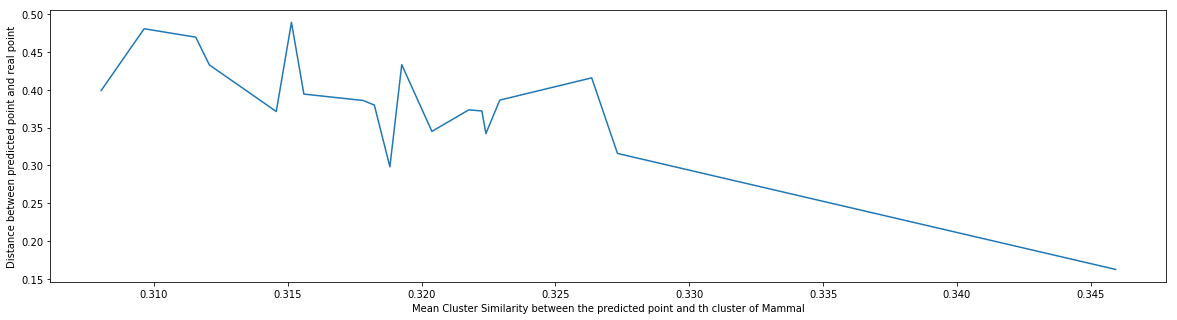

In [68]:
plt.figure(figsize=(20, 5))

a = [[x, y] for x, y in zip(mcs1, ds1)]

def sortSecond(val): 
    return val[0]  
  
a.sort(key = sortSecond)  
x = [p[0] for p in a]
y = [p[1] for p in a]

plt.xlabel('Mean Cluster Similarity between the predicted point and th cluster of Mammal')
plt.ylabel('Distance between predicted point and real point')
plt.plot(x, y)
plt.savefig('./im/mcs_vs_dist', dpi=300)


In [120]:
np.argwhere(np.isnan(res['ds']))

array([[275],
       [297],
       [483],
       [489],
       [491],
       [675],
       [717]])

In [130]:
res['centroids'][717]

array([0.18995612, 5.65254605])

In [81]:
inv_points['Amphibian']['toad']

[array([-0.05429386, -0.4584113 ,  0.1560817 , ..., -0.49403003,
         1.1189227 ,  0.9417138 ], dtype=float32),
 array([ 0.3639738 , -0.5112314 , -0.2822435 , ..., -0.20840983,
         0.3878725 ,  0.7565628 ], dtype=float32),
 array([ 0.44701207, -0.48699564, -0.32766268, ...,  0.10558607,
         1.0134478 , -0.05885457], dtype=float32),
 array([ 0.06828828, -0.9804932 , -0.3648404 , ..., -0.29104567,
         0.8558298 ,  0.22396602], dtype=float32),
 array([ 0.1384591 , -0.53939575, -0.2358904 , ..., -0.2855183 ,
         1.248964  ,  0.7105081 ], dtype=float32),
 array([ 0.11795263, -0.24999952, -0.26459837, ..., -0.10132702,
         1.2907813 ,  0.7080965 ], dtype=float32),
 array([-0.1740377 , -0.99642247, -0.22696784, ..., -0.39597422,
         0.8433224 , -0.06886414], dtype=float32),
 array([ 0.24082264, -0.63935035, -0.19589385, ..., -0.13856882,
         0.90595764,  0.56419885], dtype=float32),
 array([ 0.25680363, -0.514874  , -0.13048825, ..., -0.52726215,
       

In [154]:
parenthood

{'Mammal': {'sons': ['Cat', 'Dog', 'Horse'],
  'ancestors': ['Animal'],
  'siblings': ['Amphibian',
   'Arachnid',
   'Bird',
   'Crustacean',
   'Fish',
   'Insect',
   'Mollusca',
   'Reptile']},
 'Planet': {'sons': [],
  'ancestors': ['CelestialBody'],
  'siblings': ['Asteroid',
   'Constellation',
   'Galaxy',
   'Satellite',
   'Star',
   'Swarm']},
 'Company': {'sons': ['Publisher',
   'Airline',
   'Bank',
   'Brewery',
   'BusCompany',
   'Caterer',
   'LawFirm',
   'RecordLabel',
   'Winery'],
  'ancestors': ['Organisation'],
  'siblings': ['Broadcaster',
   'EducationalInstitution',
   'EmployersOrganisation',
   'GeopoliticalOrganisation',
   'GovernmentAgency',
   'Group',
   'InternationalOrganisation',
   'Legislature',
   'MilitaryUnit',
   'Non-ProfitOrganisation',
   'Parliament',
   'PoliticalParty',
   'PublicTransitSystem',
   'ReligiousOrganisation',
   'SambaSchool',
   'SportsClub',
   'SportsLeague',
   'SportsTeam',
   'TermOfOffice',
   'TradeUnion']},
 'City'